In [412]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

In [413]:
col_dict = {
    'GS': np.int64,
    'Rushing|Att': np.int64, 'Rushing|Yds': np.int64,'Rushing|TD': np.int64,'Receiving|Tgt': np.int64, 'Receiving|Rec': np.int64, 
    'Receiving|Yds': np.int64, 'Receiving|TD': np.int64, 'Kick Returns|Rt': np.int64, 'Kick Returns|Yds': np.int64, 'Kick Returns|TD': np.int64, 
    'Scoring|2PM': np.int64, 'Scoring|TD': np.int64, 'Scoring|Pts': np.int64, 'Fumbles|Fmb': np.int64, 'Fumbles|FL': np.int64,
    'Off. Snaps|Num': np.int64, 'ST Snaps|Num': np.int64, 'Passing|Cmp': np.int64, 'Passing|Att': np.int64, 'Passing|Yds': np.int64,
     'Passing|TD': np.int64, 'Passing|Int': np.int64, 'Passing|Sk': np.int64, 'Punt Returns|Ret': np.int64, 'Punt Returns|Yds': np.int64,'Punt Returns|TD': np.int64,
     'fantasy_points':np.float64
}

In [414]:
player_path = r'C:\Users\Tyler\OneDrive\Documents\Concatenated Fantasy Data\All_Players.csv'

player_df = pd.read_csv(player_path)
player_df = player_df[player_df['Year'] >= 2003]
player_df = player_df.replace("*",np.NaN).fillna(0.0).astype(col_dict)




C:\Users\Tyler\AppData\Local\Temp\ipykernel_65036\3136874198.py:3: DtypeWarning: Columns (51,63,65,67,68,76,89,91) have mixed types. Specify dtype option on import or set low_memory=False.
  player_df = pd.read_csv(player_path)


In [418]:
# player_df.reset_index(inplace=True)
player_df = player_df[player_df['Position'].str.contains('|'.join(['WR','QB','TE','RB']))]

In [419]:
player_df_offense = player_df[['Rk', 'Year', 'Date', 'G#', 'Week', 'Age', 'Tm',
       'Home_Away', 'Opp', 'Result', 'GS', 'Rushing|Att',
       'Rushing|Yds', 'Rushing|Y/A', 'Rushing|TD', 'Receiving|Tgt',
       'Receiving|Rec', 'Receiving|Yds', 'Receiving|Y/R', 'Receiving|TD',
       'Receiving|Ctch%', 'Receiving|Y/Tgt', 'Kick Returns|Rt',
       'Kick Returns|Yds', 'Kick Returns|Y/Rt', 'Kick Returns|TD',
       'Scoring|2PM', 'Scoring|TD', 'Scoring|Pts', 'Fumbles|Fmb', 'Fumbles|FL',
       'Fumbles|FF', 'Fumbles|FR', 'Fumbles|Yds', 'Fumbles|TD',
       'Off. Snaps|Num', 'Off. Snaps|Pct',
       'ST Snaps|Num', 'ST Snaps|Pct', 'Status', 'Position', 'Player Name',
       'Sk','Passing|Cmp', 'Passing|Att', 'Passing|Cmp%',
       'Passing|Yds', 'Passing|TD', 'Passing|Int', 'Passing|Rate',
       'Passing|Sk', 'Passing|Yds.1', 'Passing|Y/A', 'Passing|AY/A',
       'Punt Returns|Ret', 'Punt Returns|Yds', 'Punt Returns|Y/R',
       'Punt Returns|TD','player_id','Year_of_service','fantasy_points',
       'Off. Snaps Rate', 'Receiving Ctch Rate']]


In [420]:
player_df_offense_nan = player_df_offense.replace('Inactive',np.nan)

player_fantasy_df = player_df_offense_nan.fillna(0)


In [421]:
player_fantasy_df['Position'] = player_fantasy_df['Position'].str.strip()
player_fantasy_df['Position'].unique()

array(['C-TE', 'DB-WR', 'FB-TE', 'LB/RB', 'PR-WR', 'QB', 'QB/TE', 'QB-P',
       'RB', 'RB/TE', 'T-G-TE', 'T-TE', 'TE', 'TE-C', 'TE-FB', 'TE-WR',
       'WR', 'WR/CB', 'WR/RB', 'WR-RB'], dtype=object)

In [422]:
def set_position(position):
    if position in ('WR/RB', 'WR-RB'):
        return 'WR-RB'
    elif 'QB' in position:
        return 'QB'
    elif 'WR' in position:
        return 'WR'
    elif 'TE' in position:
        return 'TE'
    elif 'RB' in position:
        return 'RB'
    elif 'K' in position:
        return 'K'

In [423]:
player_fantasy_df['Clean_Position'] = player_fantasy_df['Position'].apply(lambda x: set_position(x))
player_fantasy_df['Clean_Position'].unique()

array(['TE', 'WR', 'RB', 'QB', 'WR-RB'], dtype=object)

In [425]:
player_fantasy_df['age_int'] = player_fantasy_df['Age'].astype(int)
player_fantasy_df['Total Yards'] = (player_fantasy_df['Rushing|Yds'].fillna(0).astype(np.float16) 
                + player_fantasy_df['Receiving|Yds'].fillna(0).astype(np.float16) + player_fantasy_df['Kick Returns|Yds'].fillna(0).astype(float) 
                + player_fantasy_df['Punt Returns|Yds'].fillna(0).astype(float) 

)
player_fantasy_df['Total Yards'].sort_values(ascending=False).head(2)

781060    361.0
721703    334.0
Name: Total Yards, dtype: float64

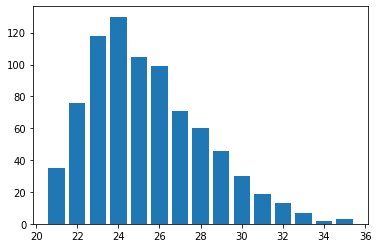

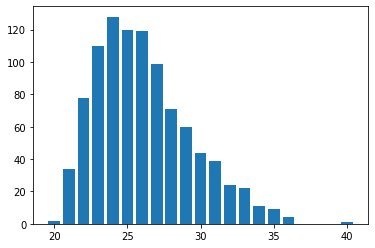

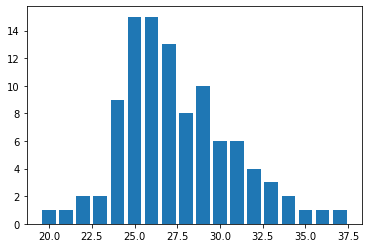

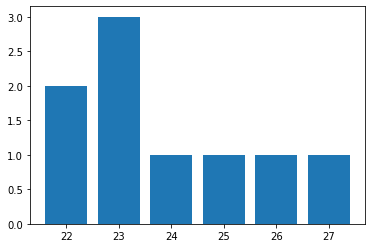

In [426]:
plyr_total_yds_yr = player_fantasy_df.groupby(['Year','player_id','Clean_Position'], as_index=False).agg({'Total Yards': 'sum','age_int':'min'}).sort_values('Total Yards',ascending=False)
plyr_yds_yr_1000= plyr_total_yds_yr[plyr_total_yds_yr['Total Yards']>=800]
plyr_count_by_age = plyr_yds_yr_1000.groupby(['age_int','Clean_Position'],as_index=False)['player_id'].nunique()

rb_count_by_age = plyr_count_by_age[plyr_count_by_age['Clean_Position']=='RB']
wr_count_by_age = plyr_count_by_age[plyr_count_by_age['Clean_Position']=='WR']
te_count_by_age = plyr_count_by_age[plyr_count_by_age['Clean_Position']=='TE']
qb_count_by_age = plyr_count_by_age[plyr_count_by_age['Clean_Position']=='QB']

plt.figure(1)
plt.bar(x=rb_count_by_age['age_int'].astype(int),height=rb_count_by_age['player_id'])
plt.figure(2)
plt.bar(x=wr_count_by_age['age_int'].astype(int),height=wr_count_by_age['player_id'])
plt.figure(3)
plt.bar(x=te_count_by_age['age_int'].astype(int),height=te_count_by_age['player_id'])
plt.figure(4)
plt.bar(x=qb_count_by_age['age_int'].astype(int),height=qb_count_by_age['player_id'])

plt.show()

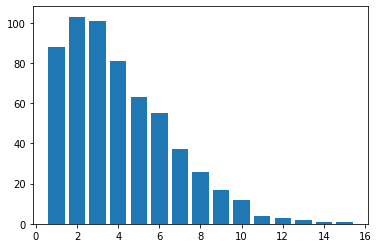

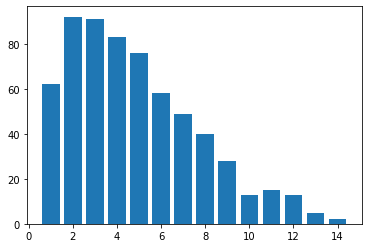

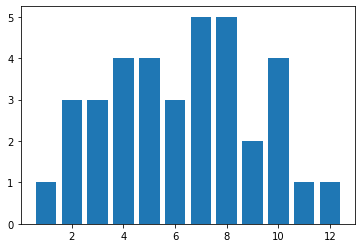

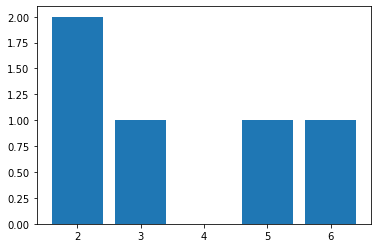

In [427]:
plyr_total_yds_yr = player_fantasy_df.groupby(['Year','player_id','Clean_Position'], as_index=False).agg({'Total Yards': 'sum','Year_of_service':'min'}).sort_values('Total Yards',ascending=False)
plyr_yds_yr_1000= plyr_total_yds_yr[plyr_total_yds_yr['Total Yards']>=1000]
plyr_count_by_age = plyr_yds_yr_1000.groupby(['Year_of_service','Clean_Position'],as_index=False)['player_id'].nunique()

rb_count_by_age = plyr_count_by_age[plyr_count_by_age['Clean_Position']=='RB']
wr_count_by_age = plyr_count_by_age[plyr_count_by_age['Clean_Position']=='WR']
te_count_by_age = plyr_count_by_age[plyr_count_by_age['Clean_Position']=='TE']
qb_count_by_age = plyr_count_by_age[plyr_count_by_age['Clean_Position']=='QB']

plt.figure(1)
plt.bar(x=rb_count_by_age['Year_of_service'].astype(int),height=rb_count_by_age['player_id'])
plt.figure(2)
plt.bar(x=wr_count_by_age['Year_of_service'].astype(int),height=wr_count_by_age['player_id'])
plt.figure(3)
plt.bar(x=te_count_by_age['Year_of_service'].astype(int),height=te_count_by_age['player_id'])
plt.figure(4)
plt.bar(x=qb_count_by_age['Year_of_service'].astype(int),height=qb_count_by_age['player_id'])

plt.show()

In [428]:
player_fantasy_df['Off. Snaps Total'] =  player_fantasy_df['Off. Snaps|Num'].fillna(0).values / player_fantasy_df['Off. Snaps Rate'].fillna(0).values 
player_fantasy_df['Off. Snaps Total'] = player_fantasy_df['Off. Snaps Total'].fillna(0).astype(int)

C:\Users\Tyler\AppData\Local\Temp\ipykernel_65036\1000463960.py:1: RuntimeWarning: invalid value encountered in true_divide
  player_fantasy_df['Off. Snaps Total'] =  player_fantasy_df['Off. Snaps|Num'].fillna(0).values / player_fantasy_df['Off. Snaps Rate'].fillna(0).values


In [430]:
agg_dict = {
    'GS': 'sum',
    'Rushing|Att': 'sum', 'Rushing|Yds': 'sum','Rushing|TD':'sum','Receiving|Tgt':'sum', 'Receiving|Rec':'sum', 
    'Receiving|Yds':'sum', 'Receiving|TD':'sum', 'Kick Returns|Rt':'sum', 'Kick Returns|Yds':'sum', 'Kick Returns|TD':'sum', 
    'Scoring|2PM':'sum', 'Scoring|TD':'sum', 'Scoring|Pts':'sum', 'Fumbles|Fmb':'sum', 'Fumbles|FL':'sum',
    'Off. Snaps|Num':'sum', 'ST Snaps|Num':'sum', 'Passing|Cmp':'sum', 'Passing|Att':'sum', 'Passing|Yds':'sum',
     'Passing|TD':'sum', 'Passing|Int':'sum', 'Passing|Sk':'sum', 'Punt Returns|Ret':'sum', 'Punt Returns|Yds':'sum','Punt Returns|TD':'sum',
     'Year_of_service':'min','fantasy_points':'sum','age_int':'min','Total Yards':'sum','Off. Snaps Total':'sum'
}


In [532]:
player_fantasy_year = player_fantasy_df[['Year','player_id','Clean_Position','Player Name','GS','Rushing|Att',
                'Rushing|Yds','Rushing|TD','Receiving|Tgt', 'Receiving|Rec', 'Receiving|Yds', 'Receiving|TD',
                'Kick Returns|Rt', 'Kick Returns|Yds', 'Kick Returns|TD', 'Scoring|2PM', 'Scoring|TD', 'Scoring|Pts',
                'Fumbles|Fmb', 'Fumbles|FL','Off. Snaps|Num', 'ST Snaps|Num', 'Passing|Cmp', 'Passing|Att', 'Passing|Yds',
                'Passing|TD', 'Passing|Int', 'Passing|Sk', 'Punt Returns|Ret', 'Punt Returns|Yds','Punt Returns|TD',
                'Year_of_service','fantasy_points','age_int','Total Yards','Off. Snaps Total']].groupby(['Year','player_id','Clean_Position','Player Name'], as_index=False).agg(agg_dict)

In [533]:
player_fantasy_year['rush_yrd_att'] = player_fantasy_year['Rushing|Yds'].values/player_fantasy_year['Rushing|Att'].values
player_fantasy_year['rec_yrd_rec'] = player_fantasy_year['Receiving|Yds'].values/player_fantasy_year['Receiving|Rec'].values
player_fantasy_year['rec_yrd_tgt'] = player_fantasy_year['Receiving|Yds'].values/player_fantasy_year['Receiving|Tgt'].values
player_fantasy_year['rec_ctch_rate'] = player_fantasy_year['Receiving|Rec'].values/player_fantasy_year['Receiving|Tgt'].values
player_fantasy_year['off_snap_rate'] = player_fantasy_year['Off. Snaps|Num'].values/player_fantasy_year['Off. Snaps Total'].values
player_fantasy_year['rec_rush_tot'] = player_fantasy_year['Rushing|Att'].values + player_fantasy_year['Receiving|Rec'].values
player_fantasy_year['fum_rate'] = player_fantasy_year['Fumbles|Fmb']/player_fantasy_year['rec_rush_tot']
player_fantasy_year['pass_comp_rate'] = player_fantasy_year['Passing|Cmp'].values/player_fantasy_year['Passing|Att'].values
player_fantasy_year['pass_yrd_comp'] = player_fantasy_year['Passing|Yds'].values/player_fantasy_year['Passing|Cmp'].values
player_fantasy_year['pass_sk_rate'] = player_fantasy_year['Passing|Sk'].values/player_fantasy_year['Passing|Att'].values
player_fantasy_year['kick_yrd_ret'] = player_fantasy_year['Kick Returns|Yds'].values/player_fantasy_year['Kick Returns|Rt'].values
player_fantasy_year['punt_yrd_ret'] = player_fantasy_year['Punt Returns|Yds'].values/player_fantasy_year['Punt Returns|Ret'].values
player_fantasy_year = player_fantasy_year.replace([np.inf, -np.inf], 0).fillna(0)
player_fantasy_year[['pass_comp_rate','rush_yrd_att','rec_yrd_rec','rec_yrd_tgt','rec_ctch_rate',
                        'off_snap_rate','rec_rush_tot','fum_rate','pass_comp_rate', 'pass_yrd_comp',
                        'pass_sk_rate', 'kick_yrd_ret', 'punt_yrd_ret']].head()

C:\Users\Tyler\AppData\Local\Temp\ipykernel_65036\2354141619.py:1: RuntimeWarning: divide by zero encountered in true_divide
  player_fantasy_year['rush_yrd_att'] = player_fantasy_year['Rushing|Yds'].values/player_fantasy_year['Rushing|Att'].values
C:\Users\Tyler\AppData\Local\Temp\ipykernel_65036\2354141619.py:1: RuntimeWarning: invalid value encountered in true_divide
  player_fantasy_year['rush_yrd_att'] = player_fantasy_year['Rushing|Yds'].values/player_fantasy_year['Rushing|Att'].values
C:\Users\Tyler\AppData\Local\Temp\ipykernel_65036\2354141619.py:2: RuntimeWarning: divide by zero encountered in true_divide
  player_fantasy_year['rec_yrd_rec'] = player_fantasy_year['Receiving|Yds'].values/player_fantasy_year['Receiving|Rec'].values
C:\Users\Tyler\AppData\Local\Temp\ipykernel_65036\2354141619.py:2: RuntimeWarning: invalid value encountered in true_divide
  player_fantasy_year['rec_yrd_rec'] = player_fantasy_year['Receiving|Yds'].values/player_fantasy_year['Receiving|Rec'].values


,pass_comp_rate,rush_yrd_att,rec_yrd_rec,rec_yrd_tgt,rec_ctch_rate,off_snap_rate,rec_rush_tot,fum_rate,pass_comp_rate,pass_yrd_comp,pass_sk_rate,kick_yrd_ret,punt_yrd_ret
0,0.00,2.06,6.88,6.11,0.89,0.00,26,0.00,0.00,0.00,0.00,12.40,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,11.67,4.38,0.38,0.00,3,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00


In [534]:
player_fantasy_year = player_fantasy_year.sort_values(by=["player_id","Year"]).reset_index()

In [535]:
player_fantasy_year[['Rushing|Att_1',
                'Rushing|Yds_1','Rushing|TD_1','Receiving|Tgt_1', 'Receiving|Rec_1', 'Receiving|Yds_1', 'Receiving|TD_1',
                'Kick Returns|Rt_1', 'Kick Returns|Yds_1', 'Kick Returns|TD_1', 'Scoring|2PM_1', 'Scoring|TD_1', 'Scoring|Pts_1',
                'Fumbles|Fmb_1', 'Fumbles|FL_1','Off. Snaps|Num_1', 'ST Snaps|Num_1', 'Passing|Cmp_1', 'Passing|Att_1', 'Passing|Yds_1',
                'Passing|TD_1', 'Passing|Int_1', 'Passing|Sk_1', 'Punt Returns|Ret_1', 'Punt Returns|Yds_1','Punt Returns|TD_1'
                ,'fantasy_points_1','Total Yards_1','Off. Snaps Total_1','rec_rush_tot_1']] = player_fantasy_year[['Rushing|Att',
                            'Rushing|Yds','Rushing|TD','Receiving|Tgt', 'Receiving|Rec', 'Receiving|Yds', 'Receiving|TD',
                            'Kick Returns|Rt', 'Kick Returns|Yds', 'Kick Returns|TD', 'Scoring|2PM', 'Scoring|TD', 'Scoring|Pts',
                            'Fumbles|Fmb', 'Fumbles|FL','Off. Snaps|Num', 'ST Snaps|Num', 'Passing|Cmp', 'Passing|Att', 'Passing|Yds',
                            'Passing|TD', 'Passing|Int', 'Passing|Sk', 'Punt Returns|Ret', 'Punt Returns|Yds','Punt Returns|TD',
                            'fantasy_points','Total Yards','Off. Snaps Total','rec_rush_tot']].rolling(1,min_periods=1,closed='left',axis=0).sum()

player_fantasy_year[['pass_comp_rate_1','rush_yrd_att_1','rec_yrd_rec_1','rec_yrd_tgt_1','rec_ctch_rate_1',
                        'off_snap_rate_1','fum_rate_1', 'pass_yrd_comp_1',
                        'pass_sk_rate_1', 'kick_yrd_ret_1', 'punt_yrd_ret_1']]= player_fantasy_year[['pass_comp_rate',
                                    'rush_yrd_att','rec_yrd_rec','rec_yrd_tgt','rec_ctch_rate',
                                    'off_snap_rate','fum_rate', 'pass_yrd_comp',
                                    'pass_sk_rate', 'kick_yrd_ret', 'punt_yrd_ret']].rolling(1,min_periods=1,closed='left',axis=0).mean()

player_fantasy_year[['Rushing|Att_3',
                'Rushing|Yds_3','Rushing|TD_3','Receiving|Tgt_3', 'Receiving|Rec_3', 'Receiving|Yds_3', 'Receiving|TD_3',
                'Kick Returns|Rt_3', 'Kick Returns|Yds_3', 'Kick Returns|TD_3', 'Scoring|2PM_3', 'Scoring|TD_3', 'Scoring|Pts_3',
                'Fumbles|Fmb_3', 'Fumbles|FL_3','Off. Snaps|Num_3', 'ST Snaps|Num_3', 'Passing|Cmp_3', 'Passing|Att_3', 'Passing|Yds_3',
                'Passing|TD_3', 'Passing|Int_3', 'Passing|Sk_3', 'Punt Returns|Ret_3', 'Punt Returns|Yds_3','Punt Returns|TD_3'
                ,'fantasy_points_3','Total Yards_3','Off. Snaps Total_3']] = player_fantasy_year[['Rushing|Att',
                            'Rushing|Yds','Rushing|TD','Receiving|Tgt', 'Receiving|Rec', 'Receiving|Yds', 'Receiving|TD',
                            'Kick Returns|Rt', 'Kick Returns|Yds', 'Kick Returns|TD', 'Scoring|2PM', 'Scoring|TD', 'Scoring|Pts',
                            'Fumbles|Fmb', 'Fumbles|FL','Off. Snaps|Num', 'ST Snaps|Num', 'Passing|Cmp', 'Passing|Att', 'Passing|Yds',
                            'Passing|TD', 'Passing|Int', 'Passing|Sk', 'Punt Returns|Ret', 'Punt Returns|Yds','Punt Returns|TD',
                            'fantasy_points','Total Yards','Off. Snaps Total']].rolling(3,min_periods=3,closed='left',axis=0).mean()

player_fantasy_year[['pass_comp_rate_3','rush_yrd_att_3','rec_yrd_rec_3','rec_yrd_tgt_3','rec_ctch_rate_3',
                        'off_snap_rate_3','fum_rate_3', 'pass_yrd_comp_3',
                        'pass_sk_rate_3', 'kick_yrd_ret_3', 'punt_yrd_ret_3']]= player_fantasy_year[['pass_comp_rate','rush_yrd_att','rec_yrd_rec','rec_yrd_tgt','rec_ctch_rate',
                                    'off_snap_rate','fum_rate', 'pass_yrd_comp',
                                    'pass_sk_rate', 'kick_yrd_ret', 'punt_yrd_ret']].rolling(3,min_periods=3,closed='left',axis=0).mean()

player_fantasy_year[['Rushing|Att_2',
                'Rushing|Yds_2','Rushing|TD_2','Receiving|Tgt_2', 'Receiving|Rec_2', 'Receiving|Yds_2', 'Receiving|TD_2',
                'Kick Returns|Rt_2', 'Kick Returns|Yds_2', 'Kick Returns|TD_2', 'Scoring|2PM_2', 'Scoring|TD_2', 'Scoring|Pts_2',
                'Fumbles|Fmb_2', 'Fumbles|FL_2','Off. Snaps|Num_2', 'ST Snaps|Num_2', 'Passing|Cmp_2', 'Passing|Att_2', 'Passing|Yds_2',
                'Passing|TD_2', 'Passing|Int_2', 'Passing|Sk_2', 'Punt Returns|Ret_2', 'Punt Returns|Yds_2','Punt Returns|TD_2'
                ,'fantasy_points_2','Total Yards_2','Off. Snaps Total_2']] = player_fantasy_year[['Rushing|Att',
                            'Rushing|Yds','Rushing|TD','Receiving|Tgt', 'Receiving|Rec', 'Receiving|Yds', 'Receiving|TD',
                            'Kick Returns|Rt', 'Kick Returns|Yds', 'Kick Returns|TD', 'Scoring|2PM', 'Scoring|TD', 'Scoring|Pts',
                            'Fumbles|Fmb', 'Fumbles|FL','Off. Snaps|Num', 'ST Snaps|Num', 'Passing|Cmp', 'Passing|Att', 'Passing|Yds',
                            'Passing|TD', 'Passing|Int', 'Passing|Sk', 'Punt Returns|Ret', 'Punt Returns|Yds','Punt Returns|TD',
                            'fantasy_points','Total Yards','Off. Snaps Total']].rolling(3,min_periods=3,closed='left',axis=0).mean()

player_fantasy_year[['pass_comp_rate_2','rush_yrd_att_2','rec_yrd_rec_2','rec_yrd_tgt_2','rec_ctch_rate_2',
                        'off_snap_rate_2','fum_rate_2', 'pass_yrd_comp_2',
                        'pass_sk_rate_2', 'kick_yrd_ret_2', 'punt_yrd_ret_2']]= player_fantasy_year[['pass_comp_rate','rush_yrd_att','rec_yrd_rec','rec_yrd_tgt','rec_ctch_rate',
                                    'off_snap_rate','fum_rate', 'pass_yrd_comp',
                                    'pass_sk_rate', 'kick_yrd_ret', 'punt_yrd_ret']].rolling(3,min_periods=3,closed='left',axis=0).mean()

player_fantasy_year[player_fantasy_year['player_id'] == 'MahoPa00'].sort_values(by='Year',ascending=False).head(20)

,index,Year,player_id,Clean_Position,Player Name,GS,Rushing|Att,Rushing|Yds,Rushing|TD,Receiving|Tgt,Receiving|Rec,Receiving|Yds,Receiving|TD,Kick Returns|Rt,Kick Returns|Yds,Kick Returns|TD,Scoring|2PM,Scoring|TD,Scoring|Pts,Fumbles|Fmb,Fumbles|FL,Off. Snaps|Num,ST Snaps|Num,Passing|Cmp,Passing|Att,Passing|Yds,Passing|TD,Passing|Int,Passing|Sk,Punt Returns|Ret,Punt Returns|Yds,Punt Returns|TD,Year_of_service,fantasy_points,age_int,Total Yards,Off. Snaps Total,rush_yrd_att,rec_yrd_rec,rec_yrd_tgt,rec_ctch_rate,off_snap_rate,rec_rush_tot,fum_rate,pass_comp_rate,pass_yrd_comp,pass_sk_rate,kick_yrd_ret,punt_yrd_ret,Rushing|Att_1,Rushing|Yds_1,Rushing|TD_1,Receiving|Tgt_1,Receiving|Rec_1,Receiving|Yds_1,Receiving|TD_1,Kick Returns|Rt_1,Kick Returns|Yds_1,Kick Returns|TD_1,Scoring|2PM_1,Scoring|TD_1,Scoring|Pts_1,Fumbles|Fmb_1,Fumbles|FL_1,Off. Snaps|Num_1,ST Snaps|Num_1,Passing|Cmp_1,Passing|Att_1,Passing|Yds_1,Passing|TD_1,Passing|Int_1,Passing|Sk_1,Punt Returns|Ret_1,Punt Returns|Yds_1,Punt Returns|TD_1,fantasy_points_1,Total Yards_1,Off. Snaps Total_1,rec_rush_tot_1,pass_comp_rate_1,rush_yrd_att_1,rec_yrd_rec_1,rec_yrd_tgt_1,rec_ctch_rate_1,off_snap_rate_1,fum_rate_1,pass_yrd_comp_1,pass_sk_rate_1,kick_yrd_ret_1,punt_yrd_ret_1,Rushing|Att_3,Rushing|Yds_3,Rushing|TD_3,Receiving|Tgt_3,Receiving|Rec_3,Receiving|Yds_3,Receiving|TD_3,Kick Returns|Rt_3,Kick Returns|Yds_3,Kick Returns|TD_3,Scoring|2PM_3,Scoring|TD_3,Scoring|Pts_3,Fumbles|Fmb_3,Fumbles|FL_3,Off. Snaps|Num_3,ST Snaps|Num_3,Passing|Cmp_3,Passing|Att_3,Passing|Yds_3,Passing|TD_3,Passing|Int_3,Passing|Sk_3,Punt Returns|Ret_3,Punt Returns|Yds_3,Punt Returns|TD_3,fantasy_points_3,Total Yards_3,Off. Snaps Total_3,pass_comp_rate_3,rush_yrd_att_3,rec_yrd_rec_3,rec_yrd_tgt_3,rec_ctch_rate_3,off_snap_rate_3,fum_rate_3,pass_yrd_comp_3,pass_sk_rate_3,kick_yrd_ret_3,punt_yrd_ret_3,Rushing|Att_2,Rushing|Yds_2,Rushing|TD_2,Receiving|Tgt_2,Receiving|Rec_2,Receiving|Yds_2,Receiving|TD_2,Kick Returns|Rt_2,Kick Returns|Yds_2,Kick Returns|TD_2,Scoring|2PM_2,Scoring|TD_2,Scoring|Pts_2,Fumbles|Fmb_2,Fumbles|FL_2,Off. Snaps|Num_2,ST Snaps|Num_2,Passing|Cmp_2,Passing|Att_2,Passing|Yds_2,Passing|TD_2,Passing|Int_2,Passing|Sk_2,Punt Returns|Ret_2,Punt Returns|Yds_2,Punt Returns|TD_2,fantasy_points_2,Total Yards_2,Off. Snaps Total_2,pass_comp_rate_2,rush_yrd_att_2,rec_yrd_rec_2,rec_yrd_tgt_2,rec_ctch_rate_2,off_snap_rate_2,fum_rate_2,pass_yrd_comp_2,pass_sk_rate_2,kick_yrd_ret_2,punt_yrd_ret_2
6382,11110,2022,MahoPa00,QB,Patrick Mahomes,0,61,358,4,1,1,6,0,0,0,0,1,4,26,5,0,1131,0,435,648,5250,41,12,26,0,0,0,6.00,507.40,26,364.00,1147,5.87,6.00,6.00,1.00,0.99,62,0.08,0.67,12.07,0.04,0.00,0.00,66.00,381.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,14.00,9.00,4.00,1164.00,0.00,436.00,658.00,4839.00,37.00,13.00,28.00,0.00,0.00,0.00,446.66,381.00,1194.00,66.00,0.66,5.77,0.00,0.00,0.00,0.97,0.14,11.10,0.04,0.00,0.00,57.00,302.33,2.00,0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.33,2.00,12.67,5.67,2.67,1023.67,0.00,381.67,576.67,4536.67,33.67,8.00,22.33,0.00,0.00,0.00,413.03,302.33,1059.33,0.66,5.27,0.00,0.00,0.00,0.97,0.10,11.96,0.04,0.00,0.00,57.00,302.33,2.00,0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.33,2.00,12.67,5.67,2.67,1023.67,0.00,381.67,576.67,4536.67,33.67,8.00,22.33,0.00,0.00,0.00,413.03,302.33,1059.33,0.66,5.27,0.00,0.00,0.00,0.97,0.10,11.96,0.04,0.00,0.00
6381,10504,2021,MahoPa00,QB,Patrick Mahomes,0,66,381,2,0,0,0,0,0,0,0,1,2,14,9,4,1164,0,436,658,4839,37,13,28,0,0,0,5.00,446.66,25,381.00,1194,5.77,0.00,0.00,0.00,0.97,66,0.14,0.66,11.10,0.04,0.00,0.00,62.00,308.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,12.00,5.00,2.00,1027.00,0.00,390.00,588.00,4740.00,38.00,6.00,22.00,0.00,0.00,0.00,450.40,308.00,1048.00,62.00,0.66,4.97,0.00,0.00,0.00,0.98,0.08,12.15,0.04,0.00,0.00,55.00,266.00,2.00,0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.33,2.00,12.67,5.67,2.00,979.67,0.00,364.00,550.67,4622.67,38.00,7.67,21.67,0.00,0.00,0.00,440.51,266.00,1009.33,0.66,4.86,0.00,0.00,0.00,0.97,0.10,12.70,0.04,0.00,0.0

In [537]:
cols = [col for col in player_fantasy_year.columns if "_1" in col]
cols += ["Clean_Position","Year_of_service","Year","fantasy_points"]

In [538]:

player_fantasy_year[cols].groupby("Clean_Position").corr(method='pearson')['fantasy_points']\
                .reset_index().sort_values(by=["Clean_Position","fantasy_points"],ascending=False)

,Clean_Position,level_1,fantasy_points
219,WR-RB,fantasy_points,1.00
184,WR-RB,Kick Returns|Yds_1,0.43
185,WR-RB,Kick Returns|TD_1,0.41
183,WR-RB,Kick Returns|Rt_1,0.38
203,WR-RB,Total Yards_1,0.27
202,WR-RB,fantasy_points_1,0.22
212,WR-RB,fum_rate_1,0.19
182,WR-RB,Receiving|TD_1,0.16
188,WR-RB,Scoring|Pts_1,0.16
187,WR-RB,Scoring|TD_1,0.16


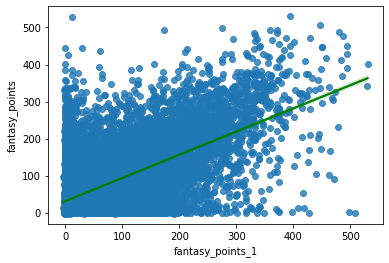

In [539]:
import seaborn as sns

sns.regplot(x="fantasy_points_1",
            y="fantasy_points",
            data=player_fantasy_year,
            line_kws={"color":"green"})
plt.show()

In [540]:
player_fantasy_df[['fantasy_points','Off. Snaps Rate']].corr(method='pearson')

,fantasy_points,Off. Snaps Rate
fantasy_points,1.00,0.36
Off. Snaps Rate,0.36,1.00


In [598]:
points_by_year= player_fantasy_year[player_fantasy_year["fantasy_points"]>200][["age_int","Clean_Position","fantasy_points"]].groupby(["age_int","Clean_Position"],as_index=False)\
                .sum()

points_by_year["percent_change"] = points_by_year.sort_values(by=["Clean_Position","age_int"])["fantasy_points"].pct_change()

points_by_year_filter = ((points_by_year["Clean_Position"] == "QB") & (points_by_year["age_int"] >= 34) |
                        (points_by_year["Clean_Position"] == "RB") & (points_by_year["age_int"] >= 27) |
                        (points_by_year["Clean_Position"] == "TE") & (points_by_year["age_int"] >= 31) |
                        (points_by_year["Clean_Position"] == "WR") & (points_by_year["age_int"] >= 29) )

age_point_reduce = points_by_year[points_by_year_filter].groupby("Clean_Position",as_index=False)["percent_change"].mean()
age_point_reduce["percent_change"] = 1 + age_point_reduce["percent_change"].values
age_point_reduce

,Clean_Position,percent_change
0,QB,0.81
1,RB,0.60
2,TE,0.86
3,WR,0.68


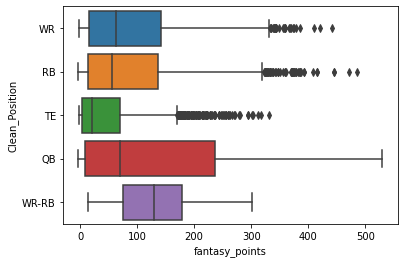

In [542]:
player_fantasy_year[["Clean_Position","fantasy_points"]].groupby("Clean_Position").agg(["std","max","min","median","mean","var"])

sns.boxplot(data=player_fantasy_year, x="fantasy_points", y="Clean_Position")

plt.show()

In [591]:
pos = player_fantasy_year["Clean_Position"].unique()
weight_list = []
for p in pos:
    q_25 = np.quantile(player_fantasy_year[player_fantasy_year["Clean_Position"]==p]["fantasy_points"],.25)
    q_75 = np.quantile(player_fantasy_year[player_fantasy_year["Clean_Position"]==p]["fantasy_points"],.75)
    q_50 = np.quantile(player_fantasy_year[player_fantasy_year["Clean_Position"]==p]["fantasy_points"],.5)
    max =  np.quantile(player_fantasy_year[player_fantasy_year["Clean_Position"]==p]["fantasy_points"],1)
    weight_list.append( (max-q_75)/max)

df = pd.DataFrame(zip(weight_list,pos),columns=["fall_off","pos"])
df

,fall_off,pos
0,0.68,WR
1,0.72,RB
2,0.79,TE
3,0.55,QB
4,0.40,WR-RB


In [593]:
def weight_ages(weighted_points,pct_change,position, age):
    if (position == "QB") & (age >=34):
        return weighted_points * pct_change 
    elif (position == "RB") & (age >=27):
        return weighted_points * pct_change
    elif (position == "WR") & (age >= 29):
        return weighted_points * pct_change
    elif (position == "TE") & (age >= 31):
        return weighted_points * pct_change
    else:
        return weighted_points

In [602]:
pd.options.display.float_format = '{:.2f}'.format
conditions = ((player_fantasy_year["Year"] == 2022))

final_df = player_fantasy_year[conditions][["fantasy_points","player_id","Clean_Position","Player Name","Off. Snaps|Num","age_int"]]\
                        .sort_values("fantasy_points", ascending=False).merge(df, left_on="Clean_Position", right_on="pos").merge(age_point_reduce, on="Clean_Position", how="left")
final_df["weighted_points"] = final_df["fall_off"].values * final_df["fantasy_points"].values
final_df["points_per_snap"] = final_df["fantasy_points"]/final_df["Off. Snaps|Num"]
final_df["weighted_points_age"] = final_df[["weighted_points","percent_change","age_int","Clean_Position"]].apply(lambda x: weight_ages(x["weighted_points"], x["percent_change"], x["Clean_Position"], x["age_int"]),axis=1)


final_df.sort_values("weighted_points_age",ascending=False).drop("percent_change",axis=1)

,fantasy_points,player_id,Clean_Position,Player Name,Off. Snaps|Num,age_int,fall_off,pos,weighted_points,points_per_snap,weighted_points_age
0,507.40,MahoPa00,QB,Patrick Mahomes,1131,26,0.55,QB,280.96,0.45,280.96
1,477.52,AlleJo02,QB,Josh Allen,1061,26,0.55,QB,264.41,0.45,264.41
87,358.36,McCaCh01,RB,Christian McCaffrey,777,26,0.72,RB,257.67,0.46,257.67
238,368.66,JeffJu00,WR,Justin Jefferson,1079,23,0.68,WR,250.14,0.34,250.14
2,428.04,HurtJa00,QB,Jalen Hurts,1028,24,0.55,QB,237.01,0.42,237.01
3,426.70,BurrJo01,QB,Joe Burrow,1091,25,0.55,QB,236.27,0.39,236.27
88,328.30,JacoJo01,RB,Josh Jacobs,821,24,0.72,RB,236.06,0.40,236.06
239,340.80,HillTy00,WR,Tyreek Hill,800,28,0.68,WR,231.23,0.43,231.23
486,316.30,KelcTr00,TE,Travis Kelce,914,32,0.79,TE,249.47,0.35,215.44
241,316.60,DiggSt00,WR,Stefon Diggs,836,28,0.68,WR,214.81,0.38,214.81


In [604]:
breakout = final_df[final_df["Off. Snaps|Num"]>100]

break_out_snaps_mean = breakout.groupby("Clean_Position")["Off. Snaps|Num"].agg({"mean","std"})
break_out_points_snap_mean = breakout.groupby("Clean_Position")["points_per_snap"].agg({"mean","std"})

breakout = breakout.merge(break_out_snaps_mean, on="Clean_Position", how="left", ).merge(
            break_out_points_snap_mean, on="Clean_Position", how="left", suffixes=["_snaps","_pps"]
                    )
breakout_filter = (breakout["Off. Snaps|Num"] <= breakout["mean_snaps"]) & (breakout["points_per_snap"] >= breakout["mean_pps"])

breakout[breakout_filter].sort_values(by=["weighted_points_age"], ascending=False)

,fantasy_points,player_id,Clean_Position,Player Name,Off. Snaps|Num,age_int,fall_off,pos,percent_change,weighted_points,points_per_snap,weighted_points_age,mean_snaps,std_snaps,mean_pps,std_pps
82,194.70,PachIs00,RB,Isiah Pacheco,351,23,0.72,RB,0.60,139.99,0.55,139.99,382.44,212.34,0.34,0.11
90,163.20,HineNy00,RB,Nyheim Hines,208,25,0.72,RB,0.60,117.35,0.78,117.35,382.44,212.34,0.34,0.11
187,167.60,WatsCh00,WR,Christian Watson,507,23,0.68,WR,0.68,113.72,0.33,113.72,520.98,291.08,0.20,0.12
195,153.60,McClRa00,WR,Ray-Ray McCloud,286,25,0.68,WR,0.68,104.22,0.54,104.22,520.98,291.08,0.20,0.12
196,152.10,DortGr01,WR,Greg Dortch,513,24,0.68,WR,0.68,103.20,0.30,103.20,520.98,291.08,0.20,0.12
197,151.80,ShahRa00,WR,Rashid Shaheed,298,24,0.68,WR,0.68,103.00,0.51,103.00,520.98,291.08,0.20,0.12
203,145.50,AgneJa00,WR,Jamal Agnew,141,27,0.68,WR,0.68,98.72,1.03,98.72,520.98,291.08,0.20,0.12
204,143.68,BerrBr00,WR,Braxton Berrios,297,26,0.68,WR,0.68,97.49,0.48,97.49,520.98,291.08,0.20,0.12
97,132.40,HerbKh00,RB,Khalil Herbert,301,24,0.72,RB,0.60,95.20,0.44,95.20,382.44,212.34,0.34,0.11
98,131.00,ForeDO00,RB,D'Onta Foreman,353,26,0.72,RB,0.60,94.19,0.37,94.19,382.44,212.34,0.34,0.11


In [630]:
rookie_year = player_fantasy_year[player_fantasy_year["Year_of_service"]==1]

rookie_year[rookie_year["Clean_Position"]=="WR"].nlargest(25,"fantasy_points").groupby("Year")["player_id"].count()

Year
2003    1
2004    1
2006    1
2007    1
2008    2
2009    3
2010    2
2012    1
2013    1
2014    4
2015    1
2016    2
2020    2
2021    3
Name: player_id, dtype: int64